## Load library and define some functions needed

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

import json
import os.path
import gc

MODEL_FILE_NAME = 'model.txt'

def transform_isrc_to_year(isrc):
    if type(isrc) != str:
        return np.nan
    # this year 2017
    suffix = int(isrc[5:7])
    return 1900 + suffix if suffix > 17 else 2000 + suffix

## Read CSV data 

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
songs_df = pd.read_csv('data/songs.csv')
song_extra_info_df = pd.read_csv('data/song_extra_info.csv')
members_df = pd.read_csv('data/members.csv')

In [3]:
song_extra_info_df['song_year'] = song_extra_info_df['isrc'].apply(transform_isrc_to_year)
song_extra_info_df.drop(['name', 'isrc'], axis=1, inplace=True)

songs_df = songs_df.merge(song_extra_info_df, on='song_id', how='left')

train_df = train_df.merge(songs_df, on='song_id', how='left')
test_df = test_df.merge(songs_df, on='song_id', how='left')

train_df = train_df.merge(members_df, on='msno', how='left')
test_df = test_df.merge(members_df, on='msno', how='left')

del members_df, song_extra_info_df
gc.collect()

for column in train_df.columns:
    if train_df[column].dtype == object:
        train_df[column] = train_df[column].astype('category')
for column in test_df.columns:
    if test_df[column].dtype == object:
        test_df[column] = test_df[column].astype('category')

x = train_df.drop(['target'], axis=1)
y = train_df['target'].values

x_test = test_df.drop(['id'], axis=1)
test_ids = test_df['id'].values

## Correlation over all features (underconstruction...)

For categorical feature, need to numerize them.
Also, for all numeric features, it's necessary to be normalized.

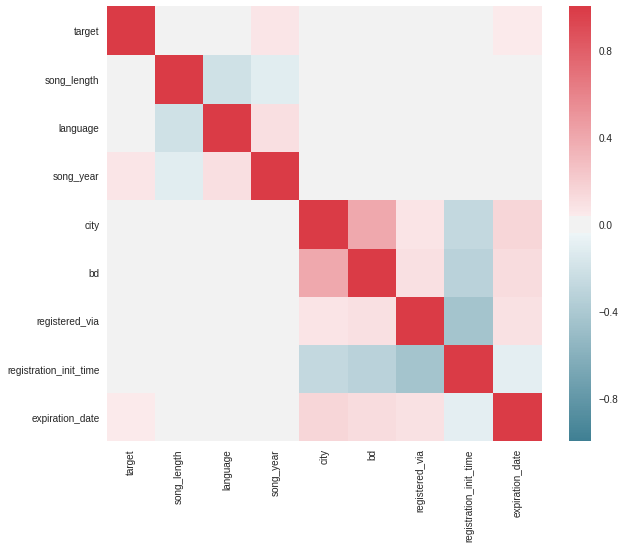

In [4]:
corr = train_df.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
sns.plt.show()